In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

In [3]:
retail = pd.read_csv('Online+Retail.csv', sep = ",", encoding= "ISO-8859-1", header= 0)

In [4]:
retail = retail.dropna()

In [5]:
retail["Amount"] = retail['Quantity']*retail['UnitPrice']
retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [6]:
grouped_df = retail.groupby('CustomerID')["Amount"].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [7]:
frequency = retail.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ["CustomerID", "Frequency"]
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [8]:
# merge the dataframes

grouped_df = pd.merge(grouped_df, frequency, on = "CustomerID", how = "inner")
grouped_df.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [9]:
# recency

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],
                                    format="%d-%m-%Y %H:%M")
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [10]:
max_date = max(retail['InvoiceDate'])

retail['diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [11]:
last_purchase = retail.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()

In [12]:
grouped_df = pd.merge(grouped_df, last_purchase, on = "CustomerID", how = "inner")
grouped_df.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']


In [13]:
grouped_df['Recency'] = grouped_df['Recency'].dt.days

In [14]:
# Will re-run the entire code again
Q1 = grouped_df.Amount.quantile(0.05)
Q3 = grouped_df.Amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Amount >= Q1 - 1.5*IQR)&(grouped_df.Amount <= Q3 + 1.5*IQR)]

Q1 = grouped_df.Frequency.quantile(0.05)
Q3 = grouped_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Frequency >= Q1 - 1.5*IQR)&(grouped_df.Frequency <= Q3 + 1.5*IQR)]

Q1 = grouped_df.Recency.quantile(0.05)
Q3 = grouped_df.Recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Recency >= Q1 - 1.5*IQR)&(grouped_df.Recency <= Q3 + 1.5*IQR)]

In [15]:
rfm_df = grouped_df[['Frequency', 'Amount', 'Recency']]

In [16]:
scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)

In [18]:
grouped_df.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [20]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']

In [21]:
rfm_df_scaled.head(5)

,Amount,Frequency,Recency
0,-0.752888,-0.723738,2.301611
1,1.042467,1.731617,-0.906466
2,-0.463636,0.300128,-0.183658
3,-0.044720,0.277517,-0.738141
4,-0.603275,-0.533235,2.143188


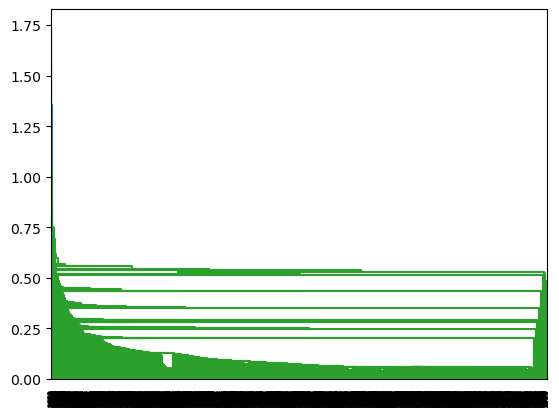

In [23]:
# single linkage (minimum distance)
mergings = linkage(rfm_df_scaled, method='single', metric='euclidean')
dendrogram(mergings)
plt.show()

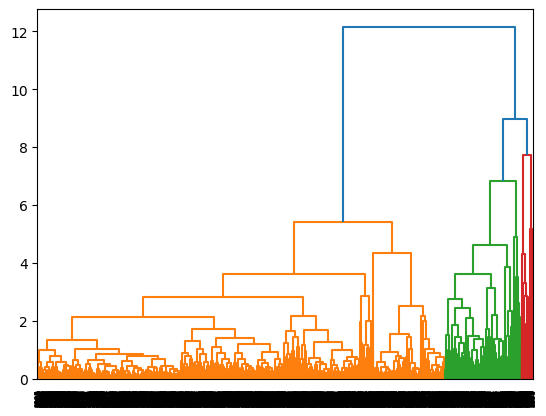

In [24]:
# complete linkage (maximum distance)
mergings = linkage(rfm_df_scaled, method='complete', metric='euclidean')
dendrogram(mergings)
plt.show()

In [26]:
# 3 clusters
cut_tree(mergings, n_clusters=3).shape

(4293, 1)

In [27]:
# reshaping the cut_tree series to a numpy series, so we can assign the values to the grouped_df dataframe
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

In [28]:
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head(5) 

,CustomerID,Amount,Frequency,Recency,cluster_labels
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


<Axes: xlabel='cluster_labels', ylabel='Amount'>

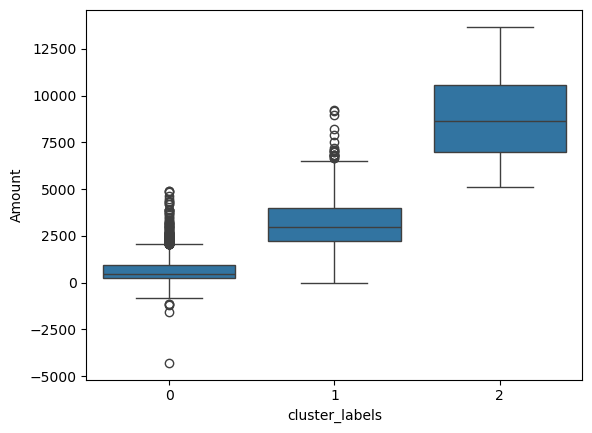

In [29]:
sns.boxplot(x = 'cluster_labels', y = 'Amount', data = grouped_df)